**Take an image and subsample it**

Saving image_a_5_2.png to image_a_5_2.png


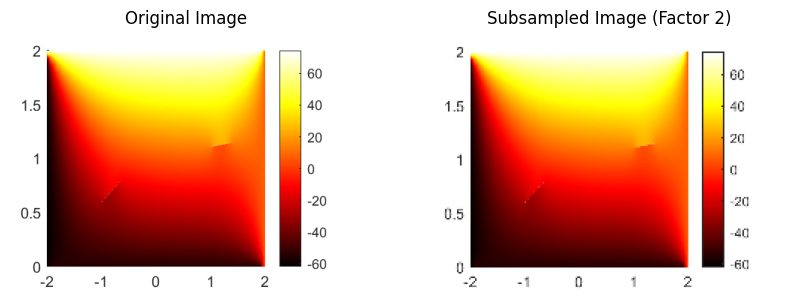

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload an image file
uploaded = files.upload()

# Get the uploaded image filename
img_filename = list(uploaded.keys())[0]

# Read the image using OpenCV
image = cv2.imread(img_filename)

# Function to subsample the image by a factor 'k'
def subsample_image(image, k):
    return image[::k, ::k]

**Solving a Forward Problem: Helmholtz Equation using the DeepXDE package**

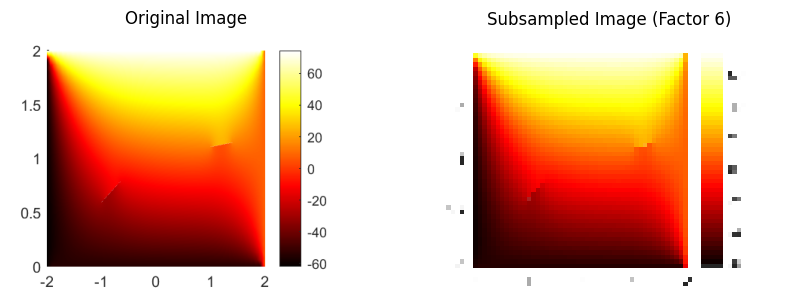

In [ ]:
# Set the subsampling factor 'k'
k = 6  # You can change this value based on your requirement

# Subsample the image
subsampled_image = subsample_image(image, k)

# Plot the original and subsampled images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Subsampled Image (Factor {k})')
plt.imshow(cv2.cvtColor(subsampled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.9 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
n = 1
length = 1
R = 1 / 4

precision_train = 15
precision_test = 30

weight_inner = 10
weight_outer = 100
iterations = 5000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 350
activation = "sin"

k0 = 2 * np.pi * n
wave_len = 1 / n

In [ ]:
if dde.backend.backend_name == "pytorch":
    import torch
    sin = torch.sin
elif dde.backend.backend_name in ["tensorflow.compat.v1", "tensorflow"]:
    from deepxde.backend import tf

    sin = tf.sin

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    f = k0**2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0**2 * y - f

In [ ]:
def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])


def boundary_outer(x, on_boundary):
    return on_boundary and outer.on_boundary(x)


def boundary_inner(x, on_boundary):
    return on_boundary and inner.on_boundary(x)

In [ ]:
def neumann(x):
  grad = np.array(
      [
          k0 * np.cos(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2]),
          k0 * np.sin(k0 * x[:, 0:1]) * np.cos(k0 * x[:, 1:2]),
      ]
  )

  normal = -inner.boundary_normal(x)
  normal = np.array([normal]).T
  result = np.sum(grad * normal, axis=0)
  return result

In [ ]:
dim_x = 1
outer = dde.geometry.Rectangle([-dim_x / 2.0, -dim_x / 2.0], [dim_x / 2.0, dim_x / 2.0])
inner = dde.geometry.Disk([0, 0], R)

geom = outer - inner

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

bc_inner = dde.icbc.NeumannBC(geom, neumann, boundary_inner)
bc_outer = dde.icbc.DirichletBC(geom, func, boundary_outer)

In [ ]:
data = dde.data.PDE(
    geom,
    pde,
    [bc_inner, bc_outer],
    num_domain=nx_train**2,
    num_boundary=16 * nx_train,
    solution=func,
    num_test=nx_test**2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

model = dde.Model(data, net)

loss_weights = [1, weight_inner, weight_outer]

In [ ]:
model.compile(
  "adam", lr=learning_rate, metrics=["l2 relative error"], loss_weights=loss_weights
)

losshistory, train_state = model.train(iterations=iterations)

Compiling model...
Building feed-forward neural network...
'build' took 0.072202 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.758167 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.40e+02, 5.90e+01, 2.11e-01]    [4.63e+02, 5.90e+01, 2.11e-01]    [1.00e+00]    
1000      [2.74e+02, 7.74e+01, 5.92e+00]    [3.35e+02, 7.74e+01, 5.92e+00]    [1.22e+00]    
2000      [2.73e+02, 7.82e+01, 6.18e+00]    [3.33e+02, 7.82e+01, 6.18e+00]    [1.23e+00]    
3000      [1.81e-01, 3.94e-03, 3.91e-02]    [2.24e-01, 3.94e-03, 3.91e-02]    [2.49e-02]    
4000      [5.92e-02, 1.23e-03, 1.71e-02]    [7.47e-02, 1.23e-03, 1.71e-02]    [1.54e-02]    
5000      [4.91e-02, 2.11e-03, 1.06e-02]    [5.68e-02, 2.11e-03, 1.06e-02]    [1.31e-02]    

Best model at step 5000:
  train loss: 6.18e-02
  test loss: 6.96e-02
  test metric: [1.31e-02]

'train' took 793.253445 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


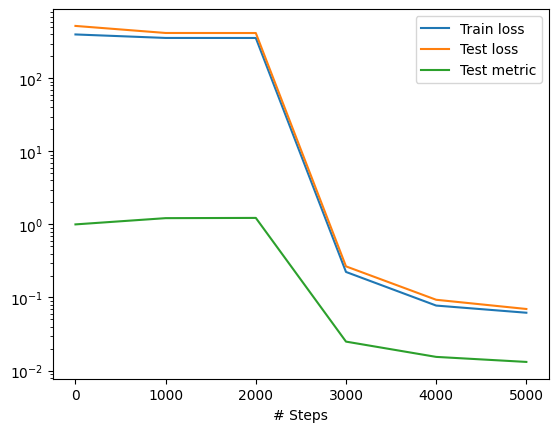

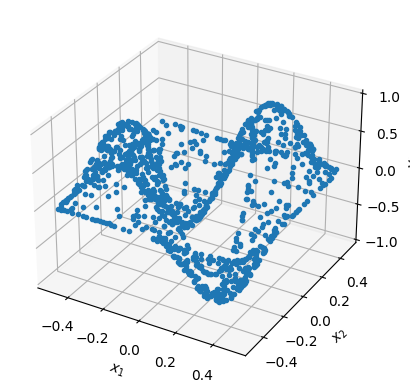

Relative error =  0.012855984155648028


<ipython-input-13-6246c5a61b1d>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("seismic"),
<ipython-input-13-6246c5a61b1d>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("seismic"),


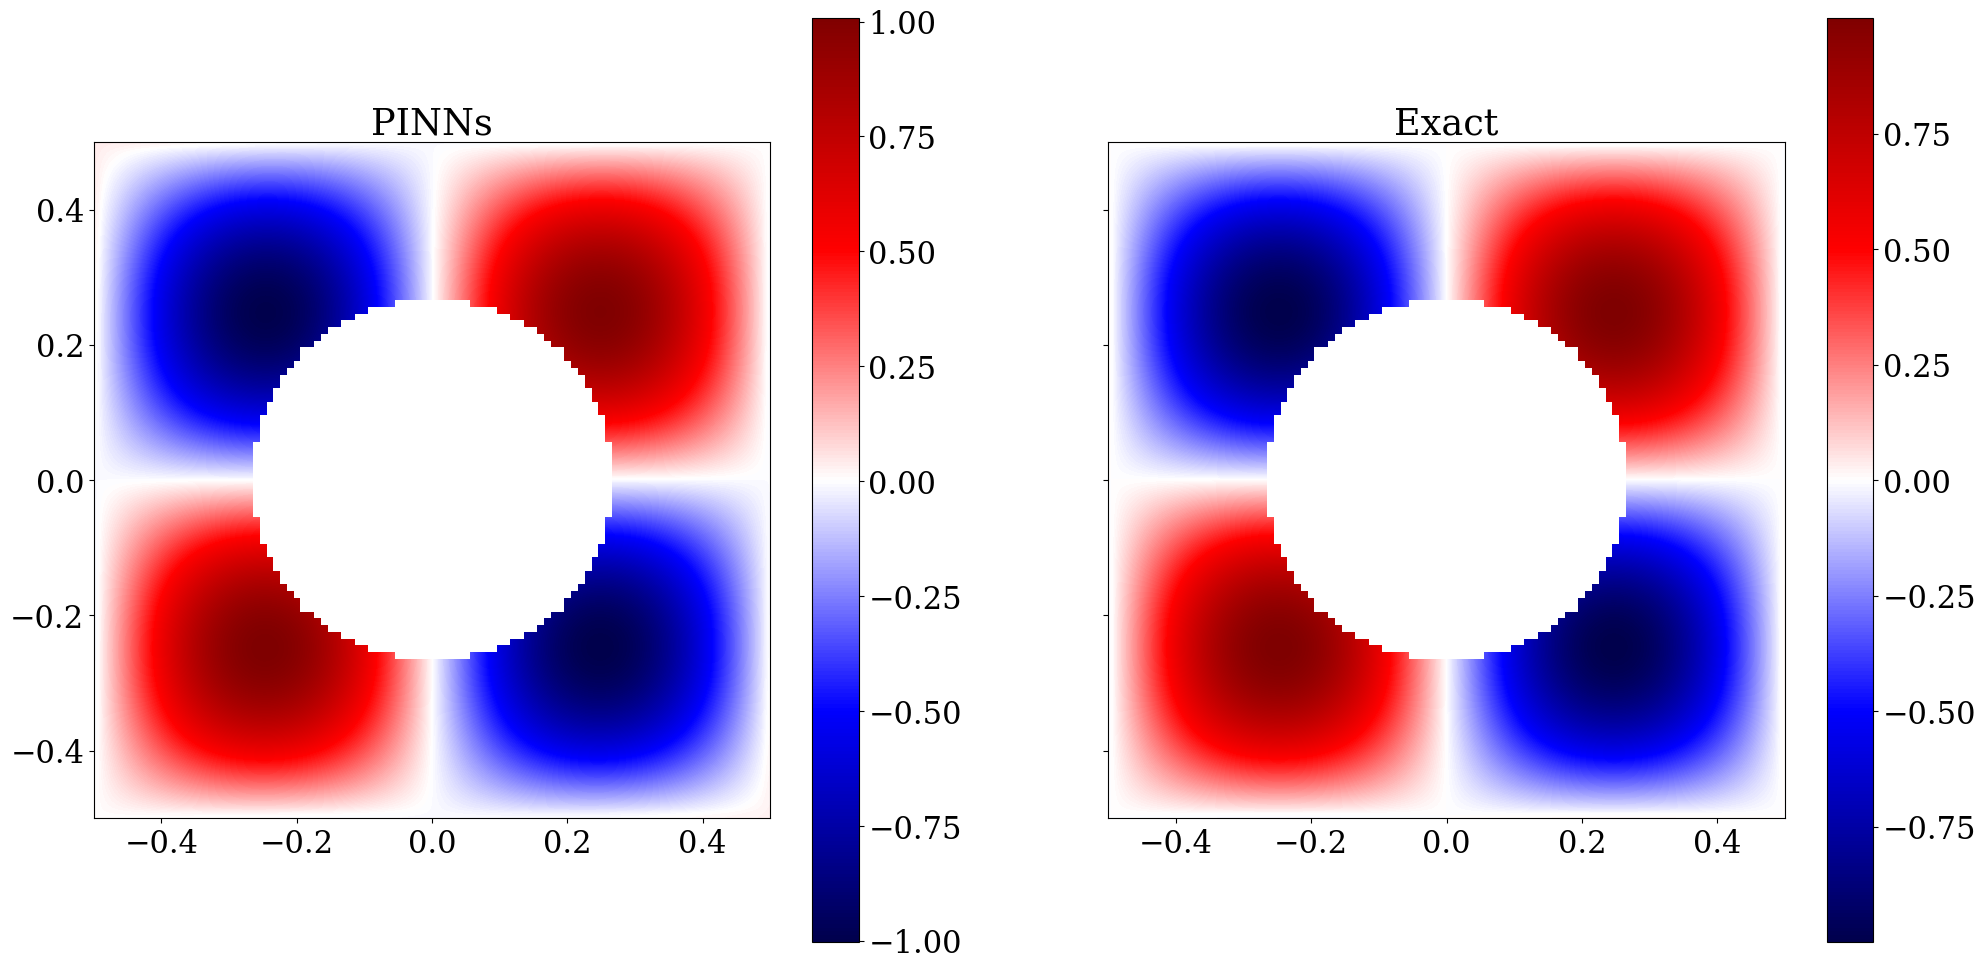

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Nx = int(np.ceil(wave_len * 100))
Ny = Nx

# Grid points
xmin, xmax, ymin, ymax = [-length / 2, length / 2, -length / 2, length / 2]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
)

points_2d = points[:2, :]
u = model.predict(points[:2, :].T)
u = u.reshape((Nx, Ny))

ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) < R
ide = ide.reshape((Nx, Nx))

u_exact = func(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact - u
error = np.linalg.norm(diff) / np.linalg.norm(u_exact)
print("Relative error = ", error)

plt.rc("font", family="serif", size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24, 12))

matrix = np.fliplr(u).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax1.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="PINN",
)

fig.colorbar(pcm, ax=ax1)

matrix = np.fliplr(u_exact).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax2.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="Exact",
)

ax1.set_title("PINNs")
ax2.set_title("Exact")
fig.colorbar(pcm, ax=ax2)

In [ ]:
# Assuming 'model' is your trained model
model.save('entire_model.h5')


'entire_model.h5-5000.ckpt'

In [ ]:
p = inner.random_boundary_points(16 * nx_train)
px, py = p.T
nx, ny = inner.boundary_normal(p).T
ax1.quiver(px, py, nx, ny)
ax2.quiver(px, py, nx, ny)
#plt.savefig("plot_manufactured.pdf")
plt.show()

Relative error =  0.012855984155648028


<ipython-input-21-4cc233d076ee>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("seismic"),
<ipython-input-21-4cc233d076ee>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("seismic"),


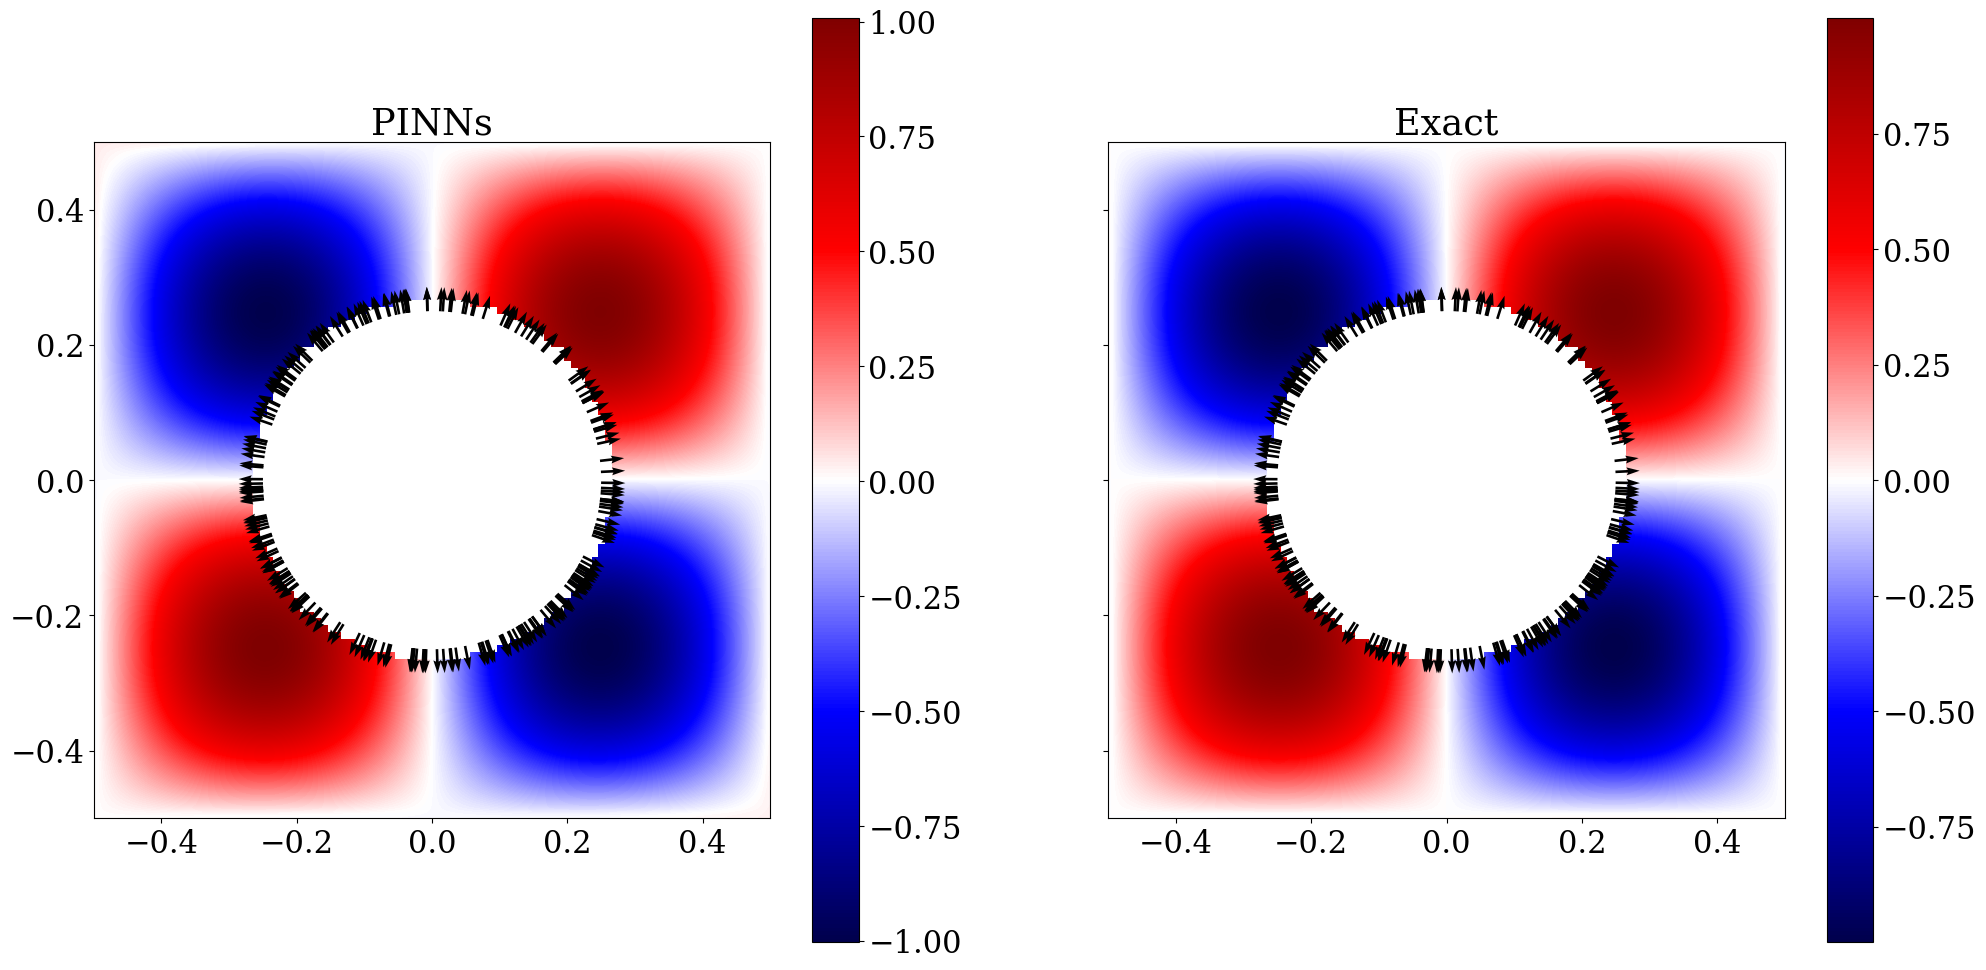

In [ ]:
# Plot the solution over a square grid with 100 points per wavelength in each direction
Nx = int(np.ceil(wave_len * 100))
Ny = Nx

# Grid points
xmin, xmax, ymin, ymax = [-length / 2, length / 2, -length / 2, length / 2]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
)

points_2d = points[:2, :]
u = model.predict(points[:2, :].T)
u = u.reshape((Nx, Ny))

ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) < R
ide = ide.reshape((Nx, Nx))

u_exact = func(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact - u
error = np.linalg.norm(diff) / np.linalg.norm(u_exact)
print("Relative error = ", error)

plt.rc("font", family="serif", size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24, 12))

matrix = np.fliplr(u).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax1.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="PINN",
)

fig.colorbar(pcm, ax=ax1)

matrix = np.fliplr(u_exact).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax2.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="Exact",
)

ax1.set_title("PINNs")
ax2.set_title("Exact")
fig.colorbar(pcm, ax=ax2)

# Add the boundary normal vectors
p = inner.random_boundary_points(16 * nx_train)
px, py = p.T
nx, ny = inner.boundary_normal(p).T
ax1.quiver(px, py, nx, ny)
ax2.quiver(px, py, nx, ny)
plt.savefig("plot_manufactured.pdf")

**Solving an inverse problem using DeepXDE**

In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

In [ ]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (
        dy_t
        - C * dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )

In [ ]:
C = dde.Variable(2.0)

In [ ]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

In [ ]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

In [ ]:
observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

In [ ]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C)

Compiling model...
Building feed-forward neural network...
'build' took 0.131104 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.623169 s



In [ ]:
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Training model...

Step      Train loss                                  Test loss                                   Test metric   
10000     [4.25e-05, 4.56e-05, 3.11e-05, 9.70e-07]    [2.21e-02, 4.56e-05, 3.11e-05, 9.70e-07]    [3.21e-01]    
10000 [1.00e+00]
11000     [3.59e-05, 3.98e-05, 2.15e-05, 6.01e-07]    [2.04e-02, 3.98e-05, 2.15e-05, 6.01e-07]    [3.22e-01]    
11000 [1.00e+00]
12000     [2.56e-05, 3.45e-05, 1.53e-05, 6.96e-07]    [1.95e-02, 3.45e-05, 1.53e-05, 6.96e-07]    [3.22e-01]    
12000 [1.00e+00]
13000     [4.84e-04, 4.38e-05, 1.23e-05, 3.26e-06]    [1.94e-02, 4.38e-05, 1.23e-05, 3.26e-06]    [3.21e-01]    
13000 [1.00e+00]
14000     [1.46e-04, 2.86e-05, 8.79e-06, 3.30e-06]    [1.85e-02, 2.86e-05, 8.79e-06, 3.30e-06]    [3.22e-01]    
14000 [1.00e+00]
15000     [1.84e-05, 2.57e-05, 6.88e-06, 5.74e-07]    [1.80e-02, 2.57e-05, 6.88e-06, 5.74e-07]    [3.22e-01]    
15000 [1.00e+00]
16000     [1.92e-05, 2.39e-05, 5.57e-06, 5.97e-07]    [1.79e-02, 2.39e-05, 5.57e-06, 5.9

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


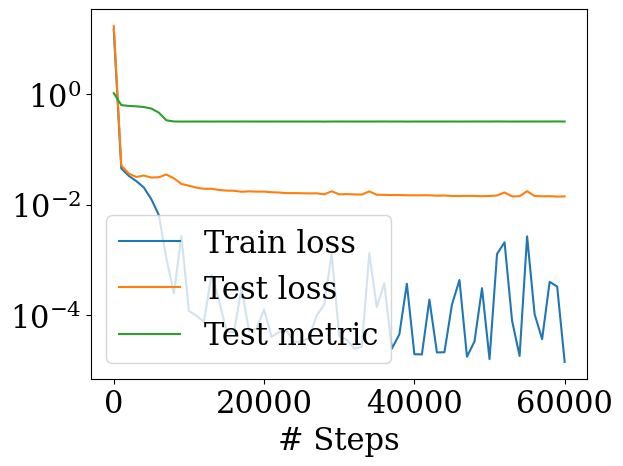

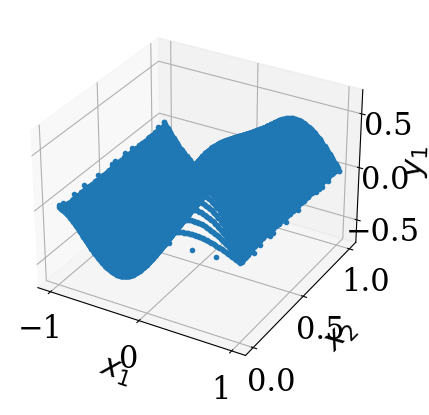

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)